# Building a Simple Text Classifier in PyTorch

Having explored the foundational concepts of converting text from human language into machine-friendly tensors, you are now ready to apply that knowledge to a practical challenge. You have seen how raw text is tokenized, transformed into numerical IDs, and then represented by meaningful vectors called embeddings that capture semantic relationships between words. This lab will guide you through the process of building a complete text classification pipeline from scratch using PyTorch. The goal is to train a model that can read the title of a recipe and classify it as either fruit-based or vegetable-based.

This hands-on lab will solidify your understanding of the entire workflow, from initial data preparation to final model evaluation. You will put theory into practice and tackle common challenges in natural language processing.

Specifically, in this lab, you'll learn to:

* **Prepare and preprocess raw text data**, which includes cleaning, tokenizing, and building a vocabulary from a training dataset to avoid data leakage.
* **Construct custom PyTorch `Dataset` and `DataLoader` objects** and implement custom `collate` functions to efficiently handle batches of variable-length text sequences.
* **Build, train, and compare multiple model architectures**. This includes an efficient model using `nn.EmbeddingBag` and others that perform manual pooling operations like mean, max, and sum.
* **Address a class imbalance problem** in the dataset by applying class weights to the loss function, a vital technique for training fair and accurate models on skewed data.
* **Evaluate your trained models** to select the best-performing one based on the F1 score and then test its predictive power on new, unseen recipe titles.

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import re
import pandas as pd

import helper_utils

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## The Recipe Dataset

For this lab, you will work with a specially prepared dataset derived from a large collection of recipes. You will load the prepared dataset and get it ready for the modeling process. This involves transforming the recipe titles and labels into a numerical format that a PyTorch model can understand.

**The Food.com Recipe Collection**

Your data originates from the [Food.com Recipes and User Interactions](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) dataset, a vast collection of over 230,000 recipes gathered over 18 years. This rich dataset contains everything from recipe names and ingredients to cooking steps and nutritional information. For the purposes of this lab, a subset of this data has been pre-created, focusing solely on recipes that are either fruit-based or vegetable-based.

**How the Subset Was Created**

The `recipes_fruit_veg.csv` file you'll use was generated by a script that filtered the original dataset. In short, the script performed the following actions:

* It scanned each recipe’s ingredients for a predefined list of common fruit and vegetable keywords.
* To create distinct categories, it only kept recipes that contained fruit keywords but no vegetable keywords, or vice versa.
* Any recipe that contained a mix of both categories, or neither, was excluded.

This process ensures the dataset has two mutually exclusive classes, which is ideal for this classification task. If you're interested, you can explore the exact logic in the `filter_recipe_dataset` function within the `helper_utils.py` file.

* Now, run the cell below to load the dataset. This will read the data from the `recipes_fruit_veg.csv` file into a pandas DataFrame called `df`.

In [3]:
# Load the filtered dataset into a pandas DataFrame
df = pd.read_csv("recipes_fruit_veg.csv")

### Preparing Inputs and Labels

Begin by inspecting the first ten rows of your DataFrame to understand its structure. This will help you see the raw text data you will be working with.

In [4]:
# Display the first 10 rows of the DataFrame
df.head(10)

,name,id,minutes,ingredients,steps,category
0,a bit different breakfast pizza,31490,30,"['prepared pizza crust', 'sausage patty', 'egg...","['preheat oven to 425 degrees f', 'press dough...",vegetable
1,all in the kitchen chili,112140,130,"['ground beef', 'yellow onions', 'diced tomato...","['brown ground beef in large pot', 'add choppe...",vegetable
2,alouette potatoes,59389,45,"['spreadable cheese with garlic and herbs', 'n...",['place potatoes in a large pot of lightly sal...,vegetable
3,apple a day milk shake,5289,0,"['milk', 'vanilla ice cream', 'frozen apple ju...","['combine ingredients in blender', 'cover and ...",fruit
4,bananas 4 ice cream pie,70971,180,"['chocolate sandwich style cookies', 'chocolat...","['crumble cookies into a 9-inch pie plate , or...",fruit
5,beat this banana bread,75452,70,"['sugar', 'unsalted butter', 'bananas', 'eggs'...","['preheat oven to 350 degrees', 'butter two 9x...",fruit
6,berry good sandwich spread,109439,5,"['whole berry cranberry sauce', 'sour cream', ...","['in medium size bowl , coarsely mash cranberr...",fruit
7,better than sex strawberries,42198,1460,"['vanilla wafers', 'butter', 'powdered sugar',...",['crush vanilla wafers into fine crumbs and li...,fruit
8,better then bush s baked beans,67547,2970,"['great northern bean', 'chicken bouillon cube...",['in a very large sauce pan cover the beans an...,vegetable
9,chicken lickin good pork chops,63986,500,"['lean pork chops', 'flour', 'salt', 'dry must...","['dredge pork chops in mixture of flour , salt...",vegetable


From the table above, you can see the different columns you have available. For your classification task, **your goal is to predict the category based on the recipe name**.

* **Model Input**: The `name` column will serve as your input feature. This is the text you will train the model to understand.

* **Model Labels**: The `category` column contains the labels ('fruit' or 'vegetable'). However, machine learning models require numerical data, not text. Your next step is to convert these string labels into numbers (e.g., 0 and 1) so the model can process them.

* Perform this conversion by creating a new `label` column and setting the default value of **1 (for 'vegetable')** and then updating the label to **0 for all 'fruit'** recipes.

In [5]:
# Create the new 'label' column and set a default value.
# Set everything to 1 (the label for 'vegetable').
df['label'] = 1

# Use boolean indexing to find all rows where the 'category' is 'fruit'
# Update the 'label' in those specific rows to 0.
df.loc[df['category'] == 'fruit', 'label'] = 0

# Display the first few rows to confirm the new column is correct
df.head()

,name,id,minutes,ingredients,steps,category,label
0,a bit different breakfast pizza,31490,30,"['prepared pizza crust', 'sausage patty', 'egg...","['preheat oven to 425 degrees f', 'press dough...",vegetable,1
1,all in the kitchen chili,112140,130,"['ground beef', 'yellow onions', 'diced tomato...","['brown ground beef in large pot', 'add choppe...",vegetable,1
2,alouette potatoes,59389,45,"['spreadable cheese with garlic and herbs', 'n...",['place potatoes in a large pot of lightly sal...,vegetable,1
3,apple a day milk shake,5289,0,"['milk', 'vanilla ice cream', 'frozen apple ju...","['combine ingredients in blender', 'cover and ...",fruit,0
4,bananas 4 ice cream pie,70971,180,"['chocolate sandwich style cookies', 'chocolat...","['crumble cookies into a 9-inch pie plate , or...",fruit,0


With the numerical `label` column now ready, you can extract the data into its final format. 

* Create two separate Python lists:
    * `texts`: A list containing the recipe names from the `name` column.
    * `labels`: A list containing the numerical labels (0 or 1) from the `label` column.

In [6]:
# Keep only rows with a recipe name.
df_clean = df.dropna(subset=['name'])

# Get recipe names as a list.
texts = df_clean['name'].tolist()

# Get matching labels as a list.
labels = df_clean['label'].tolist()

* Run the next cell to see a breakdown of the samples you'll be working with.
    * **Note**: Pay close attention to the output. You'll notice there are significantly fewer fruit recipes than vegetable recipes. This is a common issue known as data imbalance, and it's important to keep this in mind as you will address it later in the notebook.

In [7]:
# Verify the final dataset size and the class distribution.
print(f"Total samples for classification:\t{len(texts)}")
print(f"Fruit recipes:\t\t\t\t{labels.count(0)}, {round(labels.count(0)/(labels.count(0) + labels.count(1)) *100,1)} %")
print(f"Vegetable recipes:\t\t\t{labels.count(1)}, {round(labels.count(1)/(labels.count(0) + labels.count(1)) *100,1)} %")

Total samples for classification:	142915
Fruit recipes:				29148, 20.4 %
Vegetable recipes:			113767, 79.6 %


#### Previewing the Input and Labels

Your data is now structured with the `name` column as the model's input and the `label` column as its output.

* Run the cell below to review a random sample of these training pairs.

In [8]:
# Set the number of random samples to display.
num_samples = 10

# Display a sample of name and label pairs.
display(df[['name', 'label']].sample(num_samples, random_state=25).style.hide(axis="index"))

name,label
cajun tomato gravy,1
scallop soup,1
chicken piccata light,0
bombay kidney beans,1
surefire siu mai dim sum,1
linguini alla critzos,1
zuppa toscana,1
maine blueberry cake,0
lemon cream cheese coffee cake,0
sweet smoky salmon kabobs,1


## Splitting the Raw Data

To accurately judge your model's performance, you need to test it on data it has **never seen before**. This means your first step before any text processing or vocabulary building is to separate your raw texts and labels lists into two distinct groups.

The reason you do this now is to prevent **data leakage**. If you were to build your vocabulary from the **entire** dataset, the model would have already been exposed to the words in your validation data. This would not be a fair test of how it performs on new, real-world information.

By splitting the raw data first, you can build the vocabulary using only the words from one group (the training data). The other group remains completely untouched, ensuring it is a truly "unseen" set of data for your final evaluation. You perform this division as a clean, preliminary step before any PyTorch specific formatting.

* Use the <code>[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)</code> function from **scikit-learn** to handle this.
    * `texts`: The list of recipe titles you want to split.
    * `labels`: The list of corresponding labels for each recipe title.
    * `test_size=0.2`: Specifies that 20% of the data should be used for the validation set.
    * `stratify=labels`: Ensures the training and validation sets have the same class proportions as the original dataset.

In [9]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    stratify=labels
)

# Print the number of samples in each set to verify the split.
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Training samples: 114332
Validation samples: 28583


### Text Preprocessing and Vocabulary Building

With your data now split into separate groups, it's time to convert the recipe titles into a numerical format that your model can understand. This involves cleaning the text and then building a vocabulary to map each unique word to a number.

* Define the `preprocess_text` function and apply it to your recipe titles.
    * It takes a raw text string as its input, cleans the text by converting it to lowercase, and removes any characters that are not letters or spaces.
    * It then tokenizes the string by splitting it into a list of individual words.

In [10]:
def preprocess_text(text):
    """Cleans and tokenizes a raw text string.

    Args:
        text (str): The raw text to be processed.

    Returns:
        list: A list of cleaned words (tokens).
    """
    # Convert the entire text to lowercase.
    text = text.lower()
    # Remove all characters that are not letters or whitespace.
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Split the cleaned string into a list of words.
    words = text.split()

    return words

In [11]:
# Preprocess the training and validation texts separately.
processed_train_texts = [preprocess_text(text) for text in train_texts]
processed_val_texts = [preprocess_text(text) for text in val_texts]

* Define the `Vocabulary` class, which creates and manages the mapping between words and unique numerical IDs.
    * `__init__`: Initializes the vocabulary with special tokens for padding (`<pad>`) and unknown words (`<unk>`). It also sets a minimum frequency (`min_freq`) for a word to be included.
    * `build_vocab`: Scans all the processed texts, counts the frequency of every word, and adds words that meet the `min_freq` threshold to the vocabulary mapping.
    * `encode`: Takes a list of words and converts it into the corresponding list of numerical IDs. It uses the `<unk>` token's ID for any word it doesn't recognize.
    * `__len__`: Allows you to find the total number of unique items in the vocabulary by calling `len()` on the object.

In [12]:
class Vocabulary:
    """Builds and manages a word-to-index vocabulary from text.

    Attributes:
        word2idx (dict): Maps words to unique integers.
        idx2word (dict): Maps integers back to words.
        min_freq (int): Minimum word frequency for inclusion.
    """
    def __init__(self, min_freq=1):
        """Initializes the vocabulary.

        Args:
            min_freq (int): Minimum word frequency to be included.
        """
        # Mappings for word-to-index and index-to-word with special tokens.
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.min_freq = min_freq

    def build_vocab(self, texts):
        """Builds the vocabulary from a corpus of tokenized texts.

        Args:
            texts (list of list of str): A corpus of tokenized sentences.
        """
        # Count the frequency of all words in the corpus.
        word_counts = Counter(word for text in texts for word in text)
        
        # Add words to the vocabulary if they meet the minimum frequency.
        for word, count in word_counts.items():
            if count >= self.min_freq:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word

    def encode(self, text):
        """Converts a tokenized text to a sequence of indices.

        Args:
            text (list of str): Tokenized text to encode.

        Returns:
            list of int: Sequence of corresponding indices.
        """
        # Use the <unk> token for words not in the vocabulary.
        return [self.word2idx.get(word, self.word2idx['<unk>']) for word in text]

    def __len__(self):
        """Returns the vocabulary size."""
        return len(self.word2idx)

* Create a new vocabulary object to manage your word-to-number mappings.
    * `min_freq=2`: Ensures that only words appearing at least twice in your texts will be added to the vocabulary.

In [13]:
vocab = Vocabulary(min_freq=2)

* Execute the main vocabulary building process. **The vocabulary will be built using only the training data**.
    * It scans all of the `processed_texts`, counts the frequency of every word, and creates the final word-to-number mapping for all words that meet the `min_freq` rule.

In [14]:
# Build the vocabulary using ONLY the processed training texts.
vocab.build_vocab(processed_train_texts)

In [15]:
print("Number of words in the vocabulary:", len(vocab))

Number of words in the vocabulary: 8960


* Use the `vocab.encode()` method to convert your preprocessed training texts into lists of numerical IDs.
* Repeat the exact same process for your validation texts, using the same vocabulary you built from the training data.

In [16]:
# Encode both the training and validation texts using the vocabulary.
indexed_train_texts = [vocab.encode(text) for text in processed_train_texts]
indexed_val_texts = [vocab.encode(text) for text in processed_val_texts]

### Preparing Data for Training

Now that you have separate, encoded lists for your training and validation data, you can create custom PyTorch `Dataset` objects for each to encapsulate your "indexed texts" and "labels".

#### Building Your Custom `TextDataset`

* Define a custom dataset by inheriting from PyTorch's `Dataset` class.
    * `__init__`: Stores the lists of indexed texts and numerical labels. It also creates a `.classes` attribute by finding and sorting the unique values from the labels list.
    * `__len__`: Returns the total number of samples (the length of your texts list) in the dataset.
    * `__getitem__`: Retrieves a single data sample. Given an index idx, it fetches the corresponding text and label, converts them into PyTorch tensors, and returns them in a dictionary.

In [17]:
class TextDataset(Dataset):
    """
    A custom PyTorch Dataset for handling text and label data.

    This class encapsulates a dataset of texts and their corresponding labels,
    making it compatible with PyTorch's DataLoader.
    """
    def __init__(self, texts, labels):
        """
        Initializes the TextDataset object.

        Args:
            texts: A list or array of numericalized text sequences.
            labels: A list or array of corresponding labels.
        """
        # Store the collection of texts.
        self.texts = texts
        # Store the collection of labels.
        self.labels = labels
        # Find unique class labels and store them
        self.classes = sorted(list(set(labels)))

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        # Return the size of the dataset based on the number of texts.
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset at a given index.

        Args:
            idx: The index of the sample to retrieve.

        Returns:
            A dictionary containing the text and label as PyTorch tensors.
        """
        # Create a dictionary for the sample at the specified index.
        sample = {
            'text': torch.tensor(self.texts[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        
        # Return the sample dictionary.
        return sample

* Create instances of your `TextDataset` for training and validation sets.

In [18]:
# Create the training and validation datasets directly from the split data.
train_dataset = TextDataset(indexed_train_texts, train_labels)
val_dataset = TextDataset(indexed_val_texts, val_labels)

# Print the number of samples in each set to verify.
print(f"Training samples:   {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples:   114332
Validation samples: 28583


#### The Collate Function and DataLoaders

In all of your previous modules on computer vision, you saw that every image was preprocessed into a **fixed**, **uniform size** (e.g., 224x224 pixels). Since each image tensor had the exact same dimensions, the `DataLoader` could easily combine them into a single batch.

Text, however, is naturally variable. For example:

* `"apple pie"` becomes a tensor of length 2.

* `"roasted broccoli and garlic"` becomes a tensor of length 4.

This is where you'll run into an issue with the `DataLoader`'s **default configuration**. By default, it tries to create a batch by stacking the individual tensors. This operation will fail because your text tensors have different lengths, and they can't be stacked into a single, uniform tensor. This is the new challenge you must solve.

**The Solution: The `collate_fn` Parameter**

To solve this, you'll use an optional but powerful parameter of the `DataLoader` class: `collate_fn`.

This parameter lets you provide your own custom function that defines exactly how to take a list of samples from your `Dataset` and combine them into a single batch. Instead of using the default behavior, the `DataLoader` will execute your custom logic.

```python
DataLoader(dataset=...,
           batch_size=...,
           shuffle=...,
           collate_fn=... # <-- Your custom function goes here
          )
```

You are essentially telling the `DataLoader`, "Don't use your default stacking method; use my specific instructions to form a batch."

This practice of using a `collate_fn` is also the standard and most efficient method. While you could pad all sentences from the start, that approach is inefficient, leading to **significant memory and computational waste**. By using a `collate_fn` to perform "dynamic padding," each batch is only padded to the length of the longest sentence within that batch, which saves resources and speeds up training.

You will define two such functions, one for each of the model architectures that will be covered in the next section.

* First, define `collate_batch_embeddingbag`, which takes a list of samples and prepares a batch specifically formatted for PyTorch's efficient `nn.EmbeddingBag` layer (this will be covered in the next section).
    * It first extracts all the labels and text tensors from the batch.
    * It then creates a single, long 1D tensor, `flattened_text`, by concatenating all the individual text tensors together.
    * It computes an `offsets` tensor. This tensor marks the starting index of each original recipe title within the `flattened_text` tensor.
    * Finally, it returns the flattened text, the offsets, and the labels, all moved to the active device (e.g., your GPU).

In [19]:
def collate_batch_embeddingbag(batch):
    """
    Formats a batch for nn.EmbeddingBag by flattening texts and creating offsets.

    Args:
        batch (list of dict): A list of samples from the Dataset.

    Returns:
        tuple: A tuple of (flattened_text, offsets, labels) tensors.
    """
    # Extract labels from each item and create a single tensor.
    labels = torch.tensor([item['label'] for item in batch])
    # Extract the individual text tensors from the batch.
    texts = [item['text'] for item in batch]
    # Create a list of the lengths of each text, prepended with 0.
    offsets = [0] + [len(text) for text in texts]
    # Convert to a tensor of offsets representing the starting index of each sequence.
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    # Concatenate all text tensors into a single, long 1D tensor.
    flattened_text = torch.cat(texts)
    
    # Return the three tensors required for the EmbeddingBag model.
    return flattened_text.to(device), offsets.to(device), labels.to(device)

* Next, define `collate_batch_manual`, which prepares a batch using the more common technique of **padding**.
    * It starts by extracting all the labels and text tensors from the batch.
    * It then finds the length of the longest sequence (`max_len`) **within the current batch**.
    * A new tensor of zeros, `padded_texts`, is created with the shape `(batch_size, max_len)`. This acts as a template for the batch.
    * It then loops through and copies each text sequence into the `padded_texts` tensor, leaving the remaining space as zero-padding for shorter sequences.
    * Finally, it returns the single, rectangular `padded_texts` tensor and the `labels` tensor, both moved to the active device.

In [20]:
def collate_batch_manual(batch):
    """
    Formats a batch by padding texts to the same length.

    Args:
        batch (list of dict): A list of samples from the Dataset.

    Returns:
        tuple: A tuple of (padded_texts, labels) tensors.
    """
    # Extract labels from each item and create a single tensor.
    labels = torch.tensor([item['label'] for item in batch])
    # Extract the individual text tensors from the batch.
    texts = [item['text'] for item in batch]
    # Find the length of the longest sequence in this specific batch.
    max_len = max(len(text) for text in texts)
    # Create a tensor of zeros to hold the padded batch.
    padded_texts = torch.zeros(len(texts), max_len, dtype=torch.long)
    # Copy each text sequence into the corresponding row of the padded tensor.
    for i, text in enumerate(texts):
        padded_texts[i, :len(text)] = text
        
    # Return the padded texts and labels, moved to the active device.
    return padded_texts.to(device), labels.to(device)

* Create two `DataLoader` instances, `train_loader_embag` and `val_loader_embag`.
    * `collate_fn=collate_batch_embeddingbag`: Passing your custom `collate_batch_embeddingbag` function to both Dataloaders.

In [21]:
# Set the number of samples to process in each batch.
batch_size = 32

# Create the DataLoader for the training set with `collate_batch_embeddingbag`
train_loader_embag = DataLoader(train_dataset, 
                                batch_size=batch_size, 
                                shuffle=True, 
                                collate_fn=collate_batch_embeddingbag
                               )

# Create the DataLoader for the validation set with `collate_batch_embeddingbag`
val_loader_embag = DataLoader(val_dataset, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              collate_fn=collate_batch_embeddingbag
                             )

* Now, create two `DataLoader` instances, `train_loader_manual` and `val_loader_manual`.
    * `collate_fn=collate_batch_manual`: Passing your custom `collate_batch_manual` function to both Dataloaders.

In [22]:
# Create the DataLoader for the training set with `collate_batch_manual`
train_loader_manual = DataLoader(train_dataset, 
                                 batch_size=batch_size, 
                                 shuffle=True, 
                                 collate_fn=collate_batch_manual
                                )

# Create the DataLoader for the validation set with `collate_batch_manual`
val_loader_manual = DataLoader(val_dataset, 
                               batch_size=batch_size, 
                               shuffle=False, 
                               collate_fn=collate_batch_manual
                              )

## Model Architectures: EmbeddingBag vs. Manual Pooling

So far, you've completed the entire data pipeline: you've loaded, cleaned, and tokenized the text; built a numerical vocabulary; and prepared `DataLoaders` to feed batches to a model. Now, it's time to design the models that will learn from this data.

You're going to build and compare four different model architectures. The models start by converting word indices into dense embedding vectors, but they differ in the next step: how they aggregate the embeddings from a variable-length sentence into a single, fixed-size vector that can be used for classification.

1. The first model uses `nn.EmbeddingBag`, a highly efficient, built-in PyTorch layer that performs a **mean** aggregation in one go.

2. The next models use a **manual pooling** approach.  We will use three approaches where we will aggregate the embeddings by the **mean**, **max**, and **sum**.

By building and testing these, you'll discover which of the new strategies performs better for this specific task.

### EmbeddingBagClassifier

Your first model, the `EmbeddingBagClassifier`, is a simple but powerful architecture built around PyTorch's efficient `nn.EmbeddingBag` layer.

* `__init__`: Defines the three layers of the model:
    * <code>[nn.EmbeddingBag](https://docs.pytorch.org/docs/stable/generated/torch.nn.EmbeddingBag.html)</code>: This is the core of the model. In a single step, this layer takes your token IDs and their corresponding offsets and computes a fixed-size vector for each recipe title by averaging its word embeddings.
    * `nn.Dropout`: This is a standard regularization layer that helps prevent the model from overfitting.
    * `nn.Linear`: This is the final, fully connected classification layer that takes the vector from the embedding bag and outputs the raw scores for each class ('fruit' or 'vegetable').
* The `forward` method defines the actual data flow. The data passes through the layers in this order: `EmbeddingBag` → `Dropout` → `Linear`.

In [23]:
class EmbeddingBagClassifier(nn.Module):
    """
    A simple text classifier using a pre-trained nn.EmbeddingBag layer.

    Args:
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int): The size of the embedding vectors.
        num_classes (int): The number of output classes.
    """
    def __init__(self, vocab_size, embedding_dim, num_classes):
        super().__init__()
        # The core layer that efficiently computes embeddings for variable-length sequences.
        # 'mode=mean' specifies that it will average the embeddings of all words in a sequence.
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim, mode='mean')
        # A standard dropout layer for regularization to prevent overfitting.
        self.dropout = nn.Dropout(0.5)
        # The final fully connected layer that maps the embedding to the output classes.
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, text, offsets=None):
        """
        Defines the forward pass of the model.

        Args:
            text (torch.Tensor): A 1D tensor of concatenated text indices.
            offsets (torch.Tensor): A 1D tensor of starting positions for each sequence.

        Returns:
            torch.Tensor: The raw output scores (logits) for each class.
        """
        # Compute the single embedding vector for each sequence in the batch.
        embedded = self.embedding_bag(text, offsets)
        # Apply dropout to the embeddings.
        embedded = self.dropout(embedded)
        # Pass the result through the final linear layer to get class scores.
        return self.fc(embedded)

### ManualPoolingClassifier

Your other models, the `ManualPoolingClassifier`, takes a more hands-on approach where you will explicitly define the logic for aggregating the word embeddings.

* `__init__`: Defines the model's layers and configuration:
    * `nn.Embedding`: A standard embedding layer that converts your padded text's token IDs into dense vectors.
        * `padding_idx=0` is set to ensure the padding tokens are ignored during training.
    * `self.pooling`: This isn't a layer, but an attribute that stores the name of the pooling strategy (`'mean'`, `'max'`, or `'sum'`) you want to use.
    * `nn.Dropout`: A standard regularization layer.
    * `nn.Linear`: The final fully connected classification layer.
* The `forward` method defines a more complex data flow:
    * First, it gets the embeddings and creates a **mask** to ensure the padding tokens are zeroed out and don't affect the pooling calculations.
    * The `if/elif` block then uses the chosen `pooling` strategy to aggregate the word embeddings into a single, fixed-size vector for each recipe title. Because of this logic, **this single class acts as a blueprint for three distinct model variations**.
    * Finally, the resulting pooled vector is passed through `Dropout` and the final `Linear` layer to get the prediction.

In [24]:
class ManualPoolingClassifier(nn.Module):
    """
    A text classifier that uses an nn.Embedding layer followed by a manual
    pooling strategy (mean, max, or sum).

    Args:
        vocab_size (int): The size of the vocabulary.
        embedding_dim (int): The size of the embedding vectors.
        num_classes (int): The number of output classes.
        pooling (str, optional): The pooling strategy to use.
                                 Options: 'mean', 'max', 'sum'.
                                 Defaults to 'mean'.
    """
    def __init__(self, vocab_size, embedding_dim, num_classes, pooling='mean'):
        super().__init__()
        # Embedding layer that maps token IDs to vectors.
        # padding_idx=0 ensures that the padding token is ignored during training.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Store the chosen pooling strategy.
        self.pooling = pooling
        # Final fully connected layer for classification.
        self.fc = nn.Linear(embedding_dim, num_classes)
        # Dropout layer for regularization.
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        """
        Defines the forward pass of the model.

        Args:
            text (torch.Tensor): A batch of padded text indices.

        Returns:
            torch.Tensor: The raw output scores (logits) for each class.
        """
        # Get embeddings for the input text.
        # Shape: (batch_size, max_len, embedding_dim)
        embedded = self.embedding(text)

        # Create a mask to ignore padding tokens in pooling calculations.
        # The mask will have 1s for real tokens and 0s for padding tokens.
        mask = (text != 0).float().unsqueeze(-1)
        # Apply the mask by element-wise multiplication.
        embedded = embedded * mask

        # Apply the chosen pooling strategy.
        if self.pooling == 'mean':
            # Sum embeddings and divide by the actual number of non-padded tokens.
            # clamp(min=1) prevents division by zero for empty sequences.
            pooled = embedded.sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        elif self.pooling == 'max':
            # Set padded positions to negative infinity so they are ignored by max().
            embedded[mask.squeeze(-1) == 0] = float('-inf')
            pooled, _ = embedded.max(dim=1)
        elif self.pooling == 'sum':
            # Sum the embeddings of all non-padded tokens.
            pooled = embedded.sum(dim=1)

        # Apply dropout and the final linear layer.
        pooled = self.dropout(pooled)
        return self.fc(pooled)

### Initializing the Models

* Define the hyperparameters for the models.
    * `vocab_size`: The total number of unique words in your vocabulary, used to set the size of the embedding layer.
    * `embedding_dim`: A hyperparameter you choose that defines the size of the vector used to represent each word.
    * `num_classes`: The number of output categories your model will predict (in this case, 2).

In [25]:
# Define Model Hyperparameters
vocab_size = len(vocab)
embedding_dim = 64
num_classes = 2

* Initialize the EmbeddingBag model.

In [26]:
model_embag = EmbeddingBagClassifier(vocab_size, embedding_dim, num_classes)

* Next, initialize the three variants of the `ManualPoolingClassifier`, one for each pooling strategy: `'mean'`, `'max'`, and `'sum'`.

In [27]:
# Initialize the 'mean' pooling variant
model_manual_mean = ManualPoolingClassifier(vocab_size, embedding_dim, num_classes, pooling='mean')

# Initialize the 'max' pooling variant
model_manual_max = ManualPoolingClassifier(vocab_size, embedding_dim, num_classes, pooling='max')

# Initialize the 'sum' pooling variant
model_manual_sum = ManualPoolingClassifier(vocab_size, embedding_dim, num_classes, pooling='sum')

## Running the Training Experiment

With your model architectures and data loaders now fully configured, it's time to begin the training process. However, before you start training, there's one crucial issue to address that was noted during the initial data exploration.

Earlier, you saw that the dataset is quite **imbalanced**, with significantly more vegetable recipes than fruit recipes.

If you train the model on this dataset as-is, it will see the 'vegetable' class far more often. This can cause the model to become biased, learning to simply predict the majority class ('vegetable') most of the time to achieve high accuracy, while performing poorly on the minority 'fruit' class it rarely sees.

To solve this, you'll use a common and effective strategy: **class weights**. The idea is to give more importance to the under-represented class during training. By assigning a higher weight to the 'fruit' class, you tell the loss function to penalize the model more heavily for making mistakes on fruit recipes. This forces the model to pay closer attention to the minority class, leading to a more balanced and fair classifier.

### Addressing Class Imbalance

* The first step is to get a list of all the labels that belong to your **training set** to calculate the class weights.
* Since you already used `train_test_split` earlier, this list is already available in the `train_labels` variable.

In [28]:
train_labels_list = train_labels

* Use <code>[compute_class_weight()](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)</code>, a helper function from the **scikit-learn library** to automatically calculate the appropriate weights to counteract your imbalanced dataset.
    * `class_weight='balanced'`: This is the key instruction. It tells the function to automatically calculate weights that are inversely proportional to how frequently each class appears.
    * `classes=np.unique(train_labels_list)`: This parameter provides the function with a list of all the unique class labels that exist in your data, which are `[0, 1]`.
    * `y=train_labels_list`: This is the list of all the labels from your training set. The function **automatically discovers** which is the minority class by counting the occurrences of each label in this list. These counts are then used to calculate the final "balanced" weights.
        * In a scenario with more than two classes, this process works exactly the same. The function would calculate a unique weight for each class based on its frequency. If multiple classes were minority classes, they would each receive a similarly high weight.

In [29]:
# Use scikit-learn's utility to automatically calculate class weights.
class_weights = compute_class_weight(
    # The strategy for calculating weights. 'balanced' is automatic.
    class_weight='balanced',
    # The array of unique class labels (e.g., [0, 1]).
    classes=np.unique(train_labels_list),
    # The list of all training labels, used to count class frequencies.
    y=train_labels_list
)

* Convert the weights calculated by scikit-learn into the format required by PyTorch.
* The weights are first converted from a NumPy array into a PyTorch **tensor** with a `float` data type.
* The `.to(device)` then moves this tensor to your active training device (e.g., 'cuda').

In [30]:
# Convert the NumPy array of weights into a PyTorch tensor of type float
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Print the final weights to verify the calculation.
print("Calculated Class Weights:")
print(f"  - Fruit (Class 0):     {class_weights[0]:.2f}")
print(f"  - Vegetable (Class 1): {class_weights[1]:.2f}")

Calculated Class Weights:
  - Fruit (Class 0):     2.45
  - Vegetable (Class 1): 0.63


### Configuring the Loss Function

* Define `nn.CrossEntropyLoss` as your loss function.
    * The important step here is that you are passing your previously calculated `class_weights` tensor to the `weight` parameter.
        * This instructs the loss function to penalize mistakes on the minority 'fruit' class more heavily than mistakes on the majority 'vegetable' class, forcing the model to learn from both classes more equally.

In [31]:
# Initialize the CrossEntropyLoss function with the calculated `class_weights`.
loss_function = nn.CrossEntropyLoss(weight=class_weights)

### Training All Model Variants

Now you can start training your models. The `training_loop` function handles the training process and return the trained model along with a dictionary of the final validation metrics (`val_accuracy`, `val_precision`, `val_recall`, and `val_f1`).

The training loop is mostly similar to what you have seen before, with one key difference to handle the two types of models you have created:

* It checks the name of the model being trained to determine how to unpack the data batches from the `DataLoader`.
* If it's an `EmbeddingBagClassifier`, it expects a batch containing `text`, `offsets`, and `labels`, which is the output of the `collate_batch_embeddingbag` function.
* If it's a `ManualPoolingClassifier`, it expects a batch with just the padded `text` and `labels`, which is the output of the `collate_batch_manual` function.

This allows this single function to flexibly train all four of your model variations.

In [32]:
# ### Uncomment if you want to see the training loop function

# helper_utils.display_function(helper_utils.training_loop)

* First, set the number of training epochs. This value will be used for all model training runs to ensure each is trained for the same duration.

In [33]:
num_epochs = 5

* Run the training loop for the `EmbeddingBagClassifier`.
    * Notice that you are passing the `train_loader_embag` and `val_loader_embag` to the function, which were created using the specific `collate_fn` required by this model.

In [34]:
# Perform training for the EmbeddingBagClassifier.
trained_embag, results_embag = helper_utils.training_loop(
    model_embag, 
    train_loader_embag, 
    val_loader_embag, 
    loss_function,
    num_epochs, 
    device
)

# Display the results 
print("\nModel: EmbeddingBagClassifier")
helper_utils.print_final_metrics(results_embag)

--- Training EmbeddingBagClassifier ---


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.1725 | Val Loss: 0.1751 | Val Accuracy: 0.9401
--- Training complete ---

Model: EmbeddingBagClassifier

Final Validation Metrics

Accuracy:   0.9401
Precision:  0.8946
Recall:     0.9342
F1:         0.9123



* Train the `ManualPoolingClassifier` that uses the `'mean'` pooling strategy.
    * This model, along with the other manual variants, will use the `train_loader_manual` and `val_loader_manual`, which provide padded batches of data.

In [35]:
# Perform training for the ManualPoolingClassifier, `mean` variant.
trained_mean, results_mean = helper_utils.training_loop(
    model_manual_mean, 
    train_loader_manual, 
    val_loader_manual, 
    loss_function, 
    num_epochs, 
    device
)

# Display the results 
print("\nModel: ManualPoolingClassifier (MEAN)")
helper_utils.print_final_metrics(results_mean)

--- Training ManualPoolingClassifier ---


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.1723 | Val Loss: 0.1755 | Val Accuracy: 0.9416
--- Training complete ---

Model: ManualPoolingClassifier (MEAN)

Final Validation Metrics

Accuracy:   0.9416
Precision:  0.8976
Recall:     0.9341
F1:         0.9141



* Next, train the `ManualPoolingClassifier` that uses the `'max'` pooling strategy.

In [36]:
# Perform training for the ManualPoolingClassifier, `max` variant.
trained_max, results_max = helper_utils.training_loop(
    model_manual_max, 
    train_loader_manual, 
    val_loader_manual, 
    loss_function, 
    num_epochs, 
    device
)

# Display the results 
print("\nModel: ManualPoolingClassifier (MAX)")
helper_utils.print_final_metrics(results_max)

--- Training ManualPoolingClassifier ---


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.2007 | Val Loss: 0.1779 | Val Accuracy: 0.9365
--- Training complete ---

Model: ManualPoolingClassifier (MAX)

Final Validation Metrics

Accuracy:   0.9365
Precision:  0.8883
Recall:     0.9321
F1:         0.9076



* Finally, train the `ManualPoolingClassifier` that uses the `'sum'` pooling strategy.

In [37]:
# Perform training for the ManualPoolingClassifier, `sum` variant.
trained_sum, results_sum = helper_utils.training_loop(
    model_manual_sum, 
    train_loader_manual, 
    val_loader_manual, 
    loss_function, 
    num_epochs, 
    device
)

# Display the results 
print("\nModel: ManualPoolingClassifier (SUM)")
helper_utils.print_final_metrics(results_sum)

--- Training ManualPoolingClassifier ---


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.1770 | Val Loss: 0.1794 | Val Accuracy: 0.9386
--- Training complete ---

Model: ManualPoolingClassifier (SUM)

Final Validation Metrics

Accuracy:   0.9386
Precision:  0.8921
Recall:     0.9327
F1:         0.9102



You can now compare the performance of all four models based on their final validation metrics.

In [38]:
results_df = helper_utils.get_results_df(
    results_embag,
    results_mean,
    results_max,
    results_sum
)

results_df

,Val Accuracy,Val Precision,Val Recall,Val F1
Model,,,,
EmbeddingBag,0.9401,0.8946,0.9342,0.9123
ManualPooling (MEAN),0.9416,0.8976,0.9341,0.9141
ManualPooling (MAX),0.9365,0.8883,0.9321,0.9076
ManualPooling (SUM),0.9386,0.8921,0.9327,0.9102


## Best Model Selection and Evaluation

So far, you've completed the experimental phase by training four different model architectures. Each was trained under the same conditions, using class weights to handle the imbalanced dataset. This "bake-off" has given you performance metrics for each approach.

Now, it's time to move from broad experimentation to focused finalization and evaluation.

* Put all of your trained models and their results together in a single dictionary called `all_trained_data`.

In [39]:
all_trained_data = {
    'EmbeddingBag': (trained_embag, results_embag),
    'Manual (mean)': (trained_mean, results_mean),
    'Manual (max)': (trained_max, results_max),
    'Manual (sum)': (trained_sum, results_sum)
}

### Comparing Model Performance

Since you have significantly more vegetable recipes than fruit recipes, accuracy alone can be a misleading metric. A model could achieve high accuracy by simply guessing the majority class ('vegetable') every time. The **F1 score**, however, is a more robust metric for this use case because it calculates a balance between precision and recall. A high F1 score indicates that the model is performing well on both the majority and the minority classes, which is exactly what you want.

* Use the `plot_and_select_best_model` function to compare all four trained models based solely on their validation F1 score.
    * This function will visualize the results in a bar chart and then return the model instance that achieved the highest F1 score.

Best Performing Model (by F1 Score): Manual (mean)



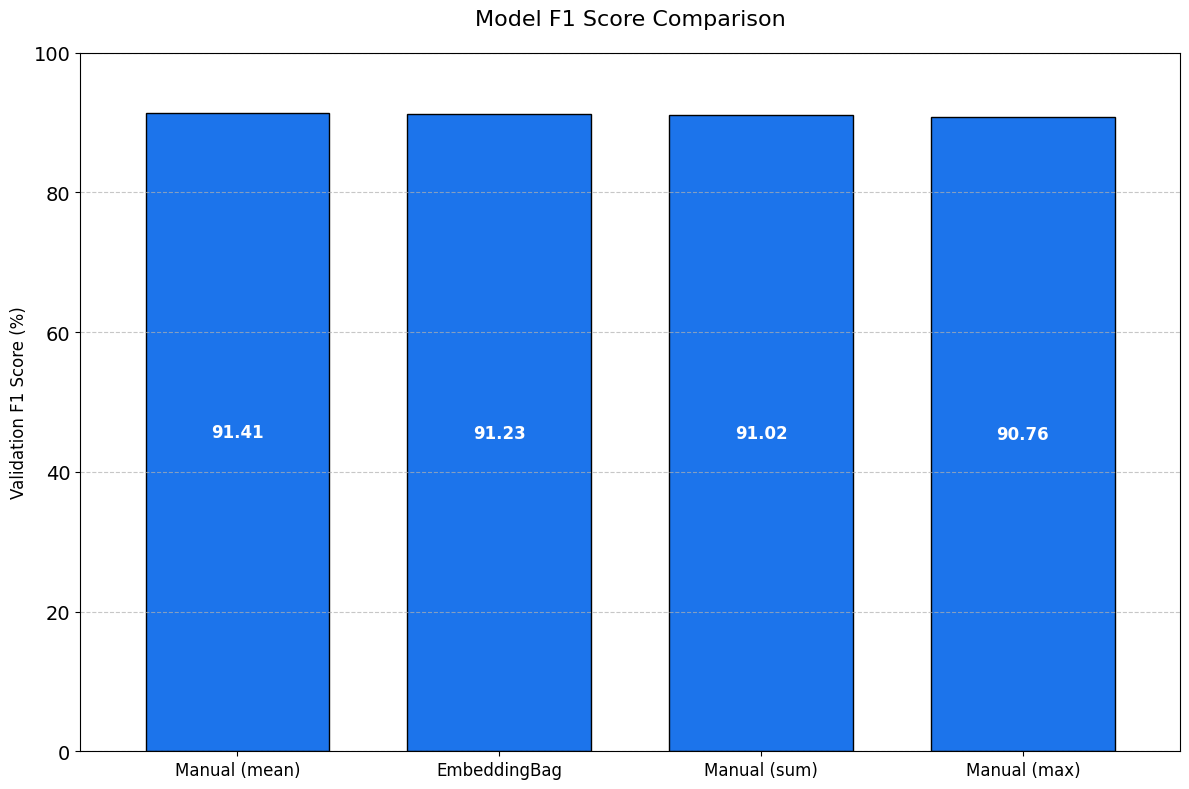

In [40]:
best_model = helper_utils.plot_and_select_best_model(all_trained_data)

### Testing the Best Model on New Examples

You've done the heavy lifting: you trained multiple architectures and systematically selected the best model.

Now for the final test. It's time to see how your best model performs on completely new, unseen data. This is the best way to get a qualitative feel for how well your model has learned to generalize.

* Define a `test_products` list containing a mix of new recipe titles. This list includes straightforward examples as well as more challenging ones to see where the model excels and where it might struggle.
    * Feel free to add your own recipe titles to this list to test the model even further!
 
**Note**: Remember, the model's predictions are based *only* on the words in the recipe's `name`. It was never shown the ingredients list, so it has no knowledge of whether fruits or vegetables are the dominant ingredient. A recipe's name can sometimes be misleading, and the model's classification will reflect only what it has learned from the title's text.

In [41]:
test_products = [
    "Blueberry Muffins",                  # Expected: Fruit
    "Spinach and Feta Stuffed Chicken",   # Expected: Vegetable
    "Classic Carrot Cake with Frosting",  # Expected: Vegetable
    "Tomato and Basil Bruschetta",        # Expected: Vegetable
    "Avocado Toast",                      # Expected: Fruit
    "Zucchini Bread with Walnuts",        # Expected: Vegetable
    "Lemon and Herb Roasted Chicken",     # Expected: Fruit
    "Strawberry Rhubarb Pie",             # Expected: Fruit
]

* Finally, loop through the `test_products` list to run the prediction for each recipe and see the model's final output.

In [42]:
## Uncomment if you want to see the predict category function

# helper_utils.display_function(helper_utils.predict_category)

In [43]:
# Loop through each test product
for product in test_products:
    # Call the prediction function with the required arguments
    category = helper_utils.predict_category(
        best_model,
        product,
        vocab,
        preprocess_text,
        device
    )
    # Print the results
    print(f"Product: '{product}'\nPredicted: {category}.\n")

Product: 'Blueberry Muffins'
Predicted: Fruit Recipe.

Product: 'Spinach and Feta Stuffed Chicken'
Predicted: Vegetable Recipe.

Product: 'Classic Carrot Cake with Frosting'
Predicted: Vegetable Recipe.

Product: 'Tomato and Basil Bruschetta'
Predicted: Vegetable Recipe.

Product: 'Avocado Toast'
Predicted: Fruit Recipe.

Product: 'Zucchini Bread with Walnuts'
Predicted: Vegetable Recipe.

Product: 'Lemon and Herb Roasted Chicken'
Predicted: Fruit Recipe.

Product: 'Strawberry Rhubarb Pie'
Predicted: Fruit Recipe.



## Conclusion

Congratulations on completing this lab! You have successfully navigated the entire pipeline for building a text classifier in PyTorch, moving from raw, unstructured text to a functional predictive model. This lab demonstrated how to translate the core concepts of text representation into a real-world application.

You began by carefully preprocessing the recipe data, building a vocabulary, and preparing `DataLoaders` that can handle the variable nature of text data, a key difference from working with fixed-size images. You implemented two distinct but related model architectures: one using the highly optimized `nn.EmbeddingBag` and another that allowed for manual control over different pooling strategies (`mean`, `max`, and `sum`). This comparison gave you direct insight into how different aggregation methods can impact performance.

Furthermore, you tackled the very common challenge of class imbalance by calculating and applying class weights, ensuring your model learned to classify both fruit and vegetable recipes effectively, rather than being biased toward the majority class. Finally, you systematically evaluated your models using the F1 score to identify the top performer and tested it on new, unseen data, which is the ultimate measure of a model's ability to generalize.

The model you built serves as an excellent baseline. The embeddings were trained from scratch on your specific dataset. The next logical step, which builds directly on these skills, is to leverage the power of **pre-trained embeddings**. Using vectors from models like GloVe or BERT, which have been trained on billions of words, can provide your model with a much richer understanding of language from the very start, often leading to significant performance gains.